In [1]:
# Set system path to allow imports
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ephys import *
from preprocessing.utils import gs_to_df
from position_analysis import *
import pandas as pd
import numpy as np

sheet = gs_to_df('https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0')
path_to_data = '/home/isabella/Documents/isabella/jake/recording_data'

sheet['path'] = f"{path_to_data}/{sheet['path']}"

sheet_inc = sheet[sheet['Include pos'] == 'Y']
trial_list = sheet_inc['trial_name']. to_list()
session_list = np.unique([f"{i.split('_')[0]}_{i.split('_')[1]}" for i in trial_list]) 

# Constants
max_speed = 5  # m/s
smoothing_window_size = 3  # Choose an appropriate window size for smoothing

#Function to construct session path
def get_path_from_session(path_to_data, session):
    animal = session.split('_')[1]
    date_short = session.split('_')[0]
    date_long = f'20{date_short[:2]}-{date_short[2:4]}-{date_short[4:6]}'
    
    session_path = f"{path_to_data}/{animal}/{date_long}"
    
    return session_path
    

In [3]:
processed_posdata = []

# Loop through sessions
trials_loaded = 0
for session in session_list:
    
    obj = ephys(recording_type = 'nexus', path = get_path_from_session(path_to_data, session))
    
    # Load position for t-maze trials
    for trial_iterator, trial in enumerate(obj.trial_list):
        if 't-maze' in trial:
            obj.load_pos(trial_iterator, reload_flag = False) #Needs reloading each time for now
            trials_loaded +=1
            
            # Extract XY position data and calculate performance using funcs from position_analysis.py
            xy_pos = obj.pos_data[trial_iterator]['xy_position']
            performance = calculate_choices(xy_pos, assign_sectors(xy_pos.T, pos_header = obj.pos_data[trial_iterator]['header']))
            
            # Add age and animal ID
            obj.pos_data[trial_iterator]['age'] = obj.age
            obj.pos_data[trial_iterator]['animal'] = obj.animal
            
            # Add processed position data to array
            processed_posdata.append({'xy_position': xy_pos,
                                      'age': obj.age,
                                      'animal': obj.animal,
                                      'performance': performance})
                                      

            
print(f'{trials_loaded} t-maze trials loaded')

# Convert processed_posdata to DataFrame
data_df = pd.DataFrame(processed_posdata)

#Extract performance metrics for plotting
data_df['total_choices'] = data_df['performance'].apply(lambda x: x['total_choices'])
data_df['p_correct'] = data_df['performance'].apply(lambda x: x['p_correct'])

Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-03/230503_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze default)
Sectors assigned incorrectly, please check
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-04/230504_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze default)
Sectors assigned incorrectly, please check
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-05/230505_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze default)
Sectors assigned incorrectly, please check
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-05/230505_r1354_raw_t-maze_2.pos
Real PPM artifically set to 615 (t-maze default)
Animal not starting trial in centre arm
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-06/230506_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze 

### Plotting:


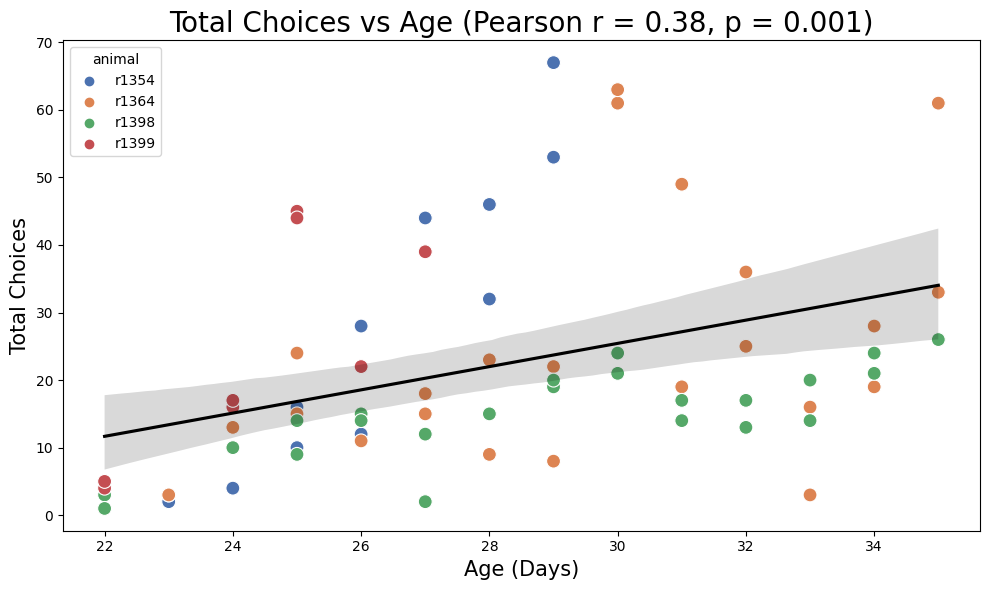

In [19]:
# Plot Total Choices vs Age

# Calculate the correlation coefficient
corr, p_val = pearsonr(df_clean['age'], df_clean['total_choices'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='age', y='total_choices', hue='animal', palette="deep", s = 100)

# If correlation is significant, add a best fit line
if p_val < 0.05:
    sns.regplot(data=df_clean, x='age', y='total_choices', scatter=False, color='black')

plt.xlabel('Age (Days)', fontsize = 15)
plt.ylabel('Total Choices', fontsize = 15)
plt.title(f"Total Choices vs Age (Pearson r = {corr:.2f}, p = {p_val:.3f})", fontsize = 20)
plt.tight_layout()
plt.savefig('/home/isabella/Documents/isabella/jake/ephys_analysis/figures/t-maze_performance/age_vs_total_choices.png')
plt.show()


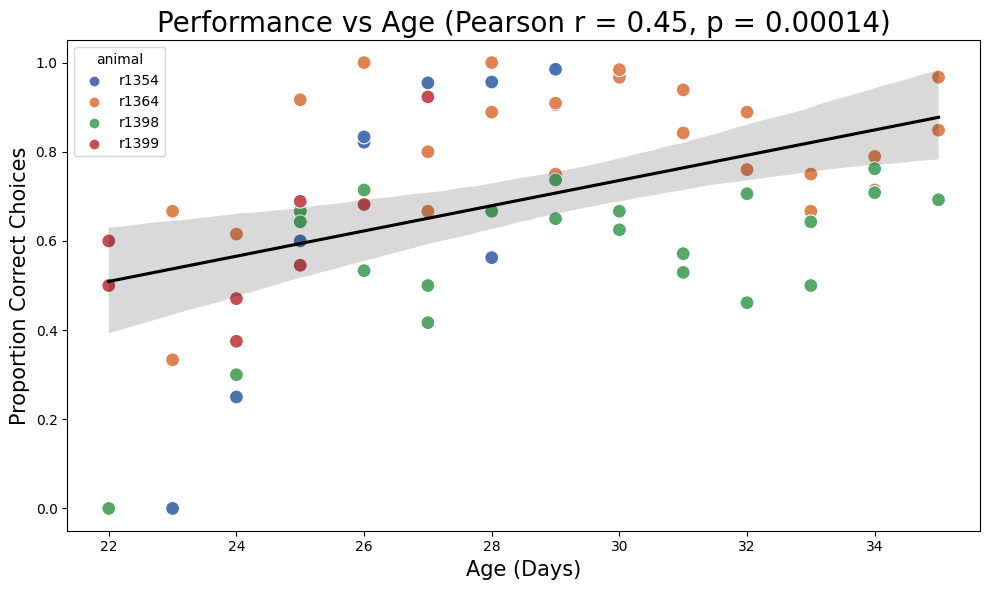

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Plot Age vs Proportion of Correct Choices

# Remove NaN values
df_clean = data_df.dropna(subset=['age', 'total_choices', 'animal', 'p_correct'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='age', y='p_correct', hue='animal', palette="deep", s = 100)

# Calculate the correlation coefficient
corr, p_val = pearsonr(df_clean['age'], df_clean['p_correct'])

# If correlation is significant, add a best fit line
if p_val < 0.05:
    sns.regplot(data=df_clean, x='age', y='p_correct', scatter=False, color='black')

plt.xlabel('Age (Days)', fontsize = 15)
plt.ylabel('Proportion Correct Choices', fontsize = 15)
plt.title(f"Performance vs Age (Pearson r = {corr:.2f}, p = {p_val:.5f})", fontsize = 20)
plt.tight_layout()
plt.savefig('/home/isabella/Documents/isabella/jake/ephys_analysis/figures/t-maze_performance/age_vs_p_correct.png')
plt.show()


In [33]:


X = xy_pos.iloc[0,:]
Y = xy_pos.iloc[1,:]
angles = direction_disp  # Random angles in radians

# Create masks for valid (non-nan) X, Y, angles, and speed data
mask = ~np.isnan(X) & ~np.isnan(Y) & ~np.isnan(angles) & ~np.isnan(speed)

# Compute arrow directions, scaled by speed
U = speed[mask] * np.cos(angles[mask])
V = speed[mask] * np.sin(angles[mask])

plt.figure()
#Plot every 10th point for visibility
plt.quiver(X[mask][::10], Y[mask][::10], U[::10], V[::10], angles='xy', scale_units='xy', scale=20)
plt.show()

NameError: name 'direction_disp' is not defined

In [ ]:
# Define the reward and start sectors
reward_sectors = [1, 9]
start_sector = 8

sector_numbers = assign_sectors(xy_pos.T)
plt.scatter(xy_pos.iloc[0,:], xy_pos.iloc[1,:], c = sector_numbers)
plt.colorbar()
plt.show()